## Intro

This is an example notebook of my workflow in manipulating and finding new features in a dataset. Then building and training a ML model and testing its performance against test data.

The dataset is Spaceship Titanic, a new version of the famous Titanic dataset where a spaceship crashes into a spacetime anomaly and some of the passengers were transported into another dimension. The goal is to predict which passengers are transported to the alternate dimension. The dataset is available on Kaggle https://www.kaggle.com/competitions/spaceship-titanic

**Purpose:** showcase skills with data cleaning, feature extraction and modeling a dataset with different kinds of features, and designing and training a ML model for prections.

**Inputs:**  
 - spaceship_titanic_train.csv - passenger information and features for training
 - spaceship_titanic_test.csv - smaller set of passenger information and features for testing.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
plt.style.use('seaborn-v0_8-ticks')

In [2]:
train = pd.read_csv("data/01 - Spaceship Titanic/spaceship_titanic_train.csv")
test = pd.read_csv("data/01 - Spaceship Titanic/spaceship_titanic_test.csv")
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


Text(0, 0.5, 'Count')

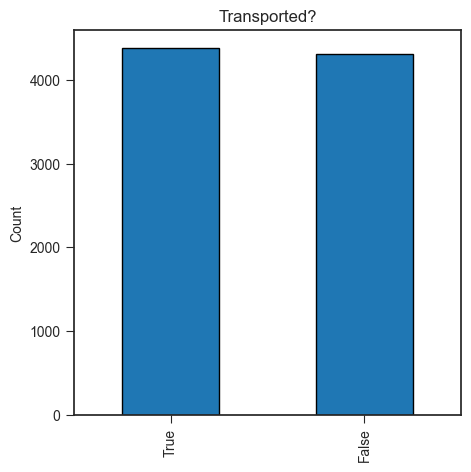

In [180]:
train.Transported.value_counts().plot(kind="bar",edgecolor="k", figsize=(5,5))
plt.title("Transported?")
plt.ylabel("Count")

Almost 50/50 split between the target prediction values. This is good, since imbalanced datasets require more adjusting.

In [109]:
# How the PassengerId column looks like further down
train.PassengerId.head(15)

0     0001_01
1     0002_01
2     0003_01
3     0003_02
4     0004_01
5     0005_01
6     0006_01
7     0006_02
8     0007_01
9     0008_01
10    0008_02
11    0008_03
12    0009_01
13    0010_01
14    0011_01
Name: PassengerId, dtype: object

Group + running value? These can be separated

In [110]:
# What home planets there are
train.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

Text(0, 0.5, 'Count')

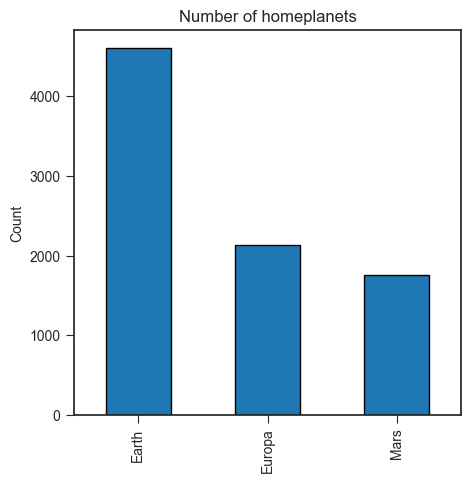

In [130]:
train.HomePlanet.value_counts().plot(kind="bar",edgecolor="k", figsize=(5,5))
plt.title("Number of homeplanets")
plt.ylabel("Count")

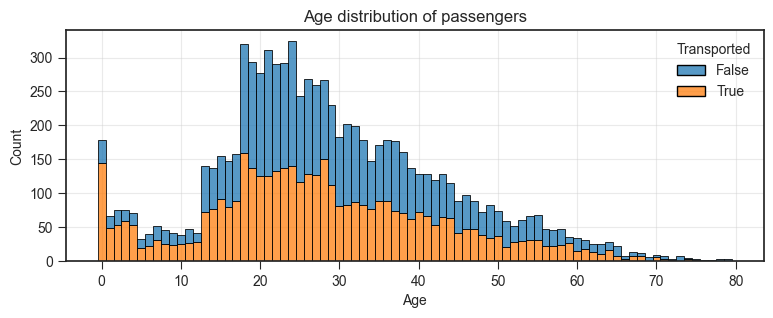

In [263]:
# Age distribution
plt.figure(figsize=(9,3))
_ = sns.histplot(data=train, x="Age", hue="Transported",discrete=True,multiple="stack")
plt.title("Age distribution of passengers")
plt.grid(alpha=0.4)

Mostly young adults between 18-40, decreasing number of older people, some teenagers and small children, many babies. Based on the age, almost in every age group half of the passengers were transported and half weren't. Except for 0-4 years olds, of whose most were transported. 

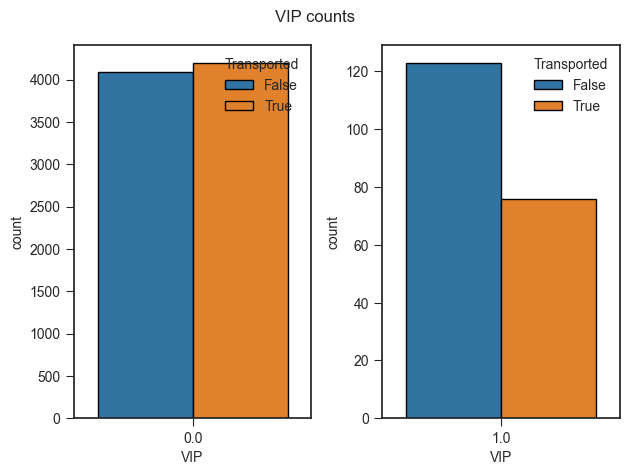

In [279]:
fig, axes = plt.subplots(1, 2)
fig.suptitle("VIP counts")
_ = sns.countplot(data=train[train.VIP==0], x="VIP", hue="Transported",edgecolor="k",ax=axes[0])
_ = sns.countplot(data=train[train.VIP==1], x="VIP", hue="Transported",edgecolor="k",ax=axes[1])
plt.tight_layout()

Firstly from VIP status we can see that there are about 8000 people without VIP status and 200 with VIP status. The people without VIP were transported in about 50/50 ratio, but from the people with VIP status the ratio is about 40/60. Meaning if you had VIP there was a slightly higher chance that you weren't transported.

In [145]:
train[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]]

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0
2,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1283.0,371.0,3329.0,193.0
4,303.0,70.0,151.0,565.0,2.0
...,...,...,...,...,...
8688,0.0,6819.0,0.0,1643.0,74.0
8689,0.0,0.0,0.0,0.0,0.0
8690,0.0,0.0,1872.0,1.0,0.0
8691,0.0,1049.0,0.0,353.0,3235.0


These five features indicate how much money did each passenger spend on the corresponding service. Since we have no idea what might be correlated to the transportation, we need to use some analysis to study this.

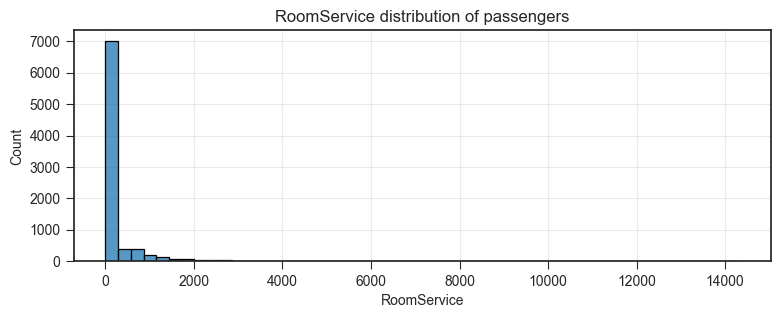

In [219]:
# Age distribution
plt.figure(figsize=(9,3))
_ = sns.histplot(train.RoomService,bins=50)
plt.title("RoomService distribution of passengers")
plt.grid(alpha=0.4)

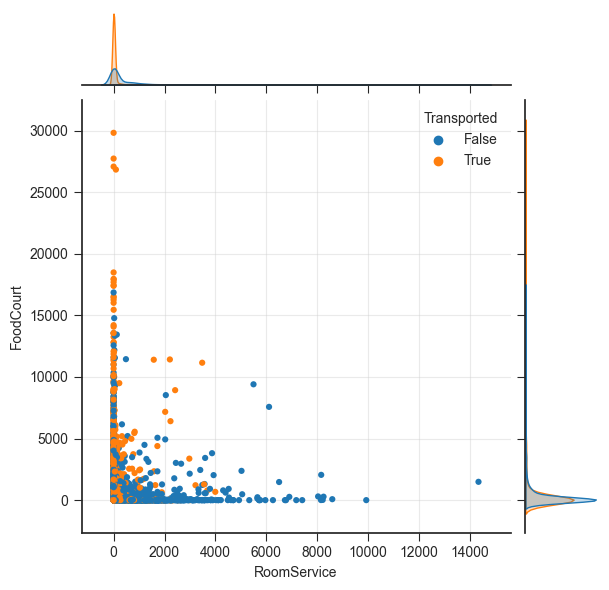

In [224]:
sns.jointplot(data=train,x="RoomService",y="FoodCourt",s=20,edgecolor="none",hue="Transported")
plt.grid(alpha=0.4)

Most passengers spend either 0 or some value close to 0. The points of the scatterplot might be overlapping, so we can't say anything for certain. 

Taking the logarithm of these values (+1 since we can't take logarithm of 0) might help to distribute the values more evenly for the machine learning algorithms (and our eyes)

In [199]:
np.log(train[["RoomService","FoodCourt"]]+1)

,RoomService,FoodCourt
0,0.000000,0.000000
1,4.700480,2.302585
2,3.784190,8.182280
3,0.000000,7.157735
4,5.717028,4.262680
...,...,...
8688,0.000000,8.827615
8689,0.000000,0.000000
8690,0.000000,0.000000
8691,0.000000,6.956545


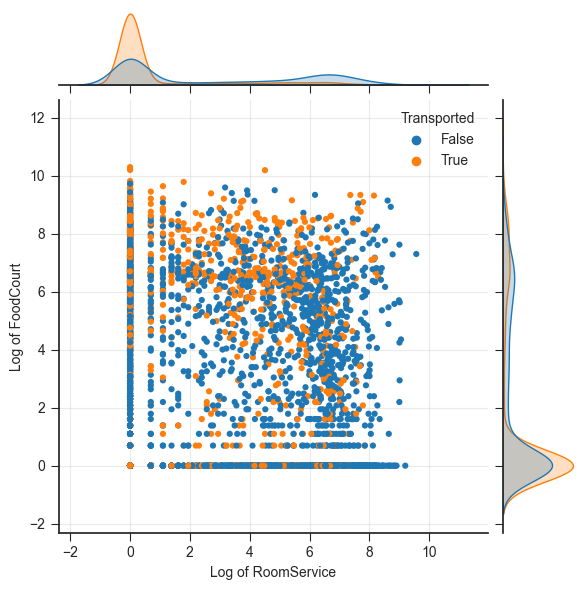

In [221]:
sns.jointplot(data=np.log(train[["RoomService","FoodCourt"]]+1), x="RoomService", y="FoodCourt",
                s=20, edgecolor="none", hue=train["Transported"])
plt.xlabel("Log of RoomService")
plt.ylabel("Log of FoodCourt")
plt.grid(alpha=0.4)

The logarithmic transformation makes the distribution slightly clearer, but there is still no clear difference of who got transported or not based on these two features. However, it looks like slightly more people who spent close to 0 did get transported compared to those who spent more money.

Lets do log transformation for all the money-features and let the ML algorithm to try to find correlations from them.

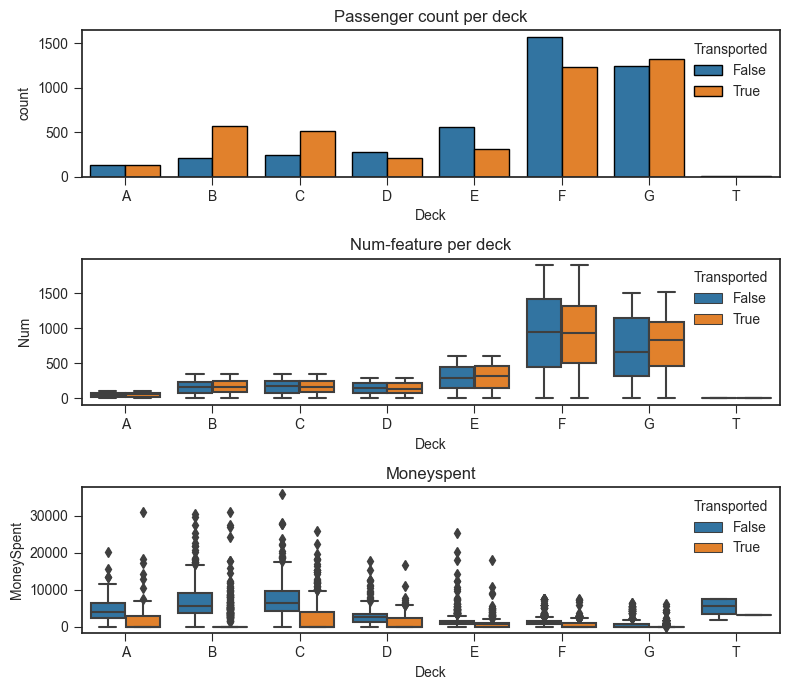

In [214]:
# Checking deck statistics
train[["Deck","Num","Side"]] = train.Cabin.str.split("/",expand=True)
train["Num"]=train["Num"].astype('Int64')
train["MoneySpent"] = train[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].sum(1)
fig, axes = plt.subplots(3,1,figsize=(8,7))
sns.countplot(data=train_fe.sort_values("Deck"), x="Deck",hue="Transported",edgecolor="k",ax=axes[0])
axes[0].set_title("Passenger count per deck")
sns.boxplot(data=train.sort_values("Deck"), x="Deck",y="Num",hue="Transported",ax=axes[1])
axes[1].set_title("Num-feature per deck")
sns.boxplot(data=train.sort_values("Deck"), x="Deck",y="MoneySpent",hue="Transported",ax=axes[2])
axes[2].set_title("Moneyspent")
plt.tight_layout()

There seems to be some ordinality in the Deck feature. If A is the top deck, the the lower we go the more passengers there are on the loewr decks. The transported ratio also changes between the decks. 

The "Num"-feature seems to be also related to the deck: The lower the deck is the higher "Num" the passengers have. Decks F and G have Num's from almost the whole range and Deck T has only couple passengers.

The money spent varies with the Deck as well, although there is a lot of variance and outliers in the amount spent. 

Text(0.5, 1.0, 'Moneyspent as a function of Num, colored by Deck')

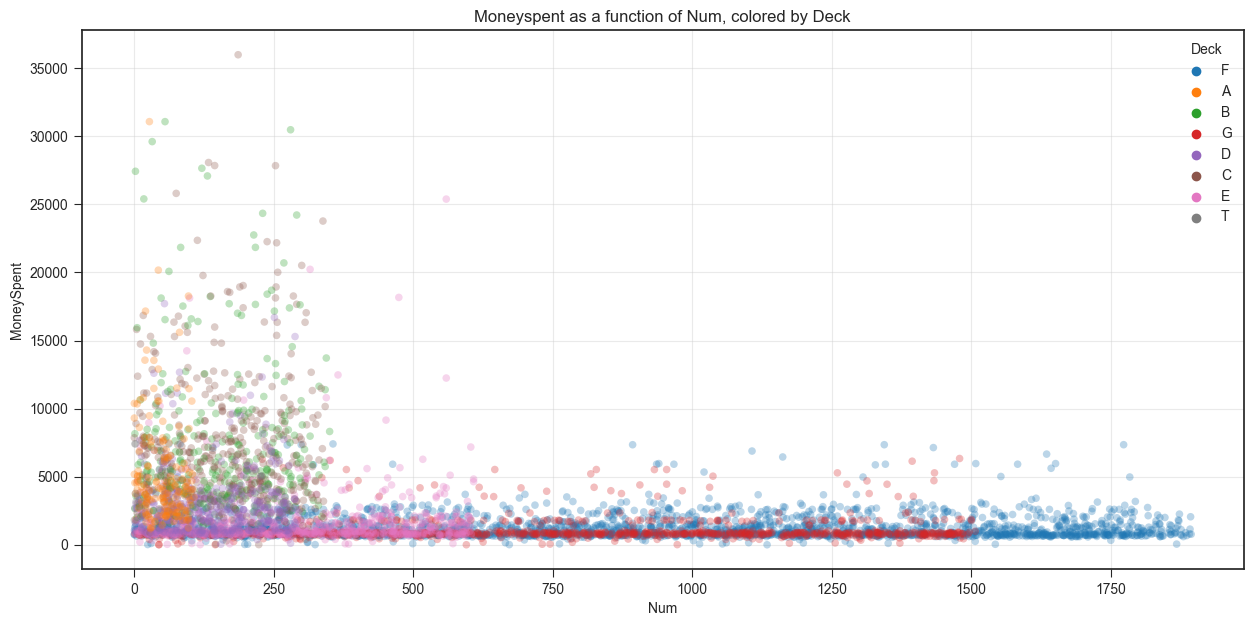

In [208]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=train[train.MoneySpent>0], x="Num", y="MoneySpent",
                s=30, edgecolor="none", hue="Deck",alpha=0.3)
plt.grid(alpha=0.4)
plt.title("Moneyspent as a function of Num, colored by Deck")

Interestingly, passengers with Num<300 spend a lot of money, whereas passengers with Num>300 don't spend that much. From the colors we can also see how the values of "Num" is distributed between the Decks.

So overall it seems that there might be some order in the values of Deck, and label encoding could be used instead of one-hot encoding, so that the Deck values from A, B, C... are turned into 0, 1, 2... (also later tests show that label encoding indeed gives better predicition results)

So, in summary we can see the following:
- PassengerID seems to be a combination of a group number and then just increasing number if the passengers belong to the same group. So let's separate the prefix into a "group" and also count how many passengers are in that group.
- Cabin column is a combination of deck, some number and side. Separate these.
- CryoSleep and VIP are booleans, lets turn them into binary
- Some passenger's home planets are missing. Each group has one home planet, so we can replace the missing values if there are other passengers in the same group whose home planet we know
- Lets add a "MoneySpent" column, that is the sum of all five columns about money spent.
- One-hot encode the homeplanet for the classifier.
- There are missing values in other columns as well. For the model we don't want NaNs, so lets fill those values. Instead of filling them with average numbers or based on the previous/next values, lets use IterativeImputer, which tries to "impute the missing values by modeling each feature with missing values as a function of other features in a round-robin fashion." For this all the columns need to be numeric. Lets Label Encode the destination column which is in strings, then do Iterative Imputing, inverse transform the destinations back to strings and then one-hot encode those.
- Drop passengerID, Cabin and Name
- Label encode Deck
- One-hot encode side
- The money-features seem to be focused on either 0 or some small values. For slightly better model performance, lets do a logarithmic transformation for them to make them more evenly spaced.
- Some column names (destinations such as 55 Cancri e) have whitespaces which some of the ML don't like, so remove the whitespaces with .replace(' ', '_')

Let's write a function for this so that we can use it for both train and test sets.

In [241]:
# The feature engineering function
def fe(train):
    train["Group"] = train.PassengerId.str.split("_",expand=True).loc[:,0].astype(int)
    train['GCount'] = train.groupby('Group')['Group'].transform('count')
    train[["Deck","Num","Side"]] = train.Cabin.str.split("/",expand=True)
    train["Num"]=train["Num"].astype('Int64')
    train.CryoSleep = train.CryoSleep.replace({True: 1, False: 0})
    train.VIP = train.VIP.replace({True: 1, False: 0})
    HomePlanetMap = train.dropna(subset="HomePlanet").groupby("Group").first().HomePlanet
    train["HomePlanet"] = train.set_index("Group").HomePlanet.fillna(HomePlanetMap).values
    train["MoneySpent"] = train[["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]].sum(1)
    train = pd.get_dummies(train,columns=['HomePlanet'])
    
    # Dest to numbers
    le = preprocessing.LabelEncoder()
    le.fit(train['Destination'])
    train['Destination'] = le.transform(train['Destination'])
    
    # Impute missing values
    imp = IterativeImputer(max_iter=10, random_state=0, min_value=0)
    numeric_columns = train.select_dtypes(include='number').columns
    train[numeric_columns] = pd.DataFrame(imp.fit_transform(train[numeric_columns]), columns=numeric_columns).astype(int)
    
    # Dest to string, string to dummies
    train['Destination'] = le.inverse_transform(train['Destination'])
    train = pd.get_dummies(train,columns=['Destination'])
    
    train = train.drop(["PassengerId","Cabin","Name"],axis=1)
    
    #train = pd.get_dummies(train,columns=['Deck','Side'])
    train = pd.get_dummies(train,columns=['Side'])
    le.fit(train['Deck'])
    train['Deck'] = le.transform(train['Deck'])
    
    for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','MoneySpent']:
        train[col]=np.log(1+train[col])
        
    train.columns = train.columns.str.replace(' ', '_')
    
    return train

In [242]:
# Process the data, standardize it and split to train and test sets
train = pd.read_csv("data/spaceship_titanic_train.csv")
train_fe = fe(train)
y = train_fe["Transported"]
X = train_fe.drop(["Transported"],axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

Lets try 3 different models:
- Logisting regression, a simple statistical regression model that predicts the binary output based on the features.
- Random forest, a popular model that uses the combined result of multiple decision trees for predictions.
- LightGBM, a lightweight and fast XGBoost-type model. Performs well on bigger dataset. 

In [254]:
# Lets do 5-fold cross validation for each model
kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=5, random_state=42, shuffle=True)


In [260]:
%%time
training_scores=[]
testing_scores=[]
model_LR = LogisticRegression(random_state=0)

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    model_LR.fit(X_train,y_train)
    pred_y = model_LR.predict(X_test)
    training_scores.append(model_LR.score(X_train, y_train))
    testing_scores.append(model_LR.score(X_test, y_test))
    
print('Training set score: {:.4f}'.format(np.mean(training_scores)))
print('Test set score: \033[1m {:.4f}\033[0m'.format(np.mean(testing_scores)))

Training set score: 0.7759
Test set score:  0.7752
CPU times: total: 219 ms
Wall time: 198 ms


In [262]:
%%time
training_scores=[]
testing_scores=[]
model_RF = RandomForestClassifier(random_state=0)

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    model_RF.fit(X_train,y_train)
    pred_y = model_RF.predict(X_test)
    training_scores.append(model_RF.score(X_train, y_train))
    testing_scores.append(model_RF.score(X_test, y_test))
    
print('Training set score: {:.4f}'.format(np.mean(training_scores)))
print('Test set score: \033[1m {:.4f}\033[0m'.format(np.mean(testing_scores)))

Training set score: 0.9998
Test set score:  0.7983
CPU times: total: 9.48 s
Wall time: 9.47 s


In [263]:
%%time
training_scores=[]
testing_scores=[]
model_LGBM = lgb.LGBMClassifier(random_state=0)

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    model_LGBM.fit(X_train,y_train)
    pred_y = model_LGBM.predict(X_test)
    training_scores.append(model_LGBM.score(X_train, y_train))
    testing_scores.append(model_LGBM.score(X_test, y_test))
    
print('Training set score: {:.4f}'.format(np.mean(training_scores)))
print('Test set score: \033[1m {:.4f}\033[0m'.format(np.mean(testing_scores)))

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2168
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
[LightGBM] [Info] Number of positive: 3492, number of negative: 3462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2168
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502157 -> initscore=0.008628
[LightGBM] 

LightGBM results in the best test set score. Random forest's training set score is almost 1, which means it managed to divide the training data almost perfectly according to the target values, but since the test set score is not really high, it is probably overfitting. Logitic regression was fast but did only ok. 

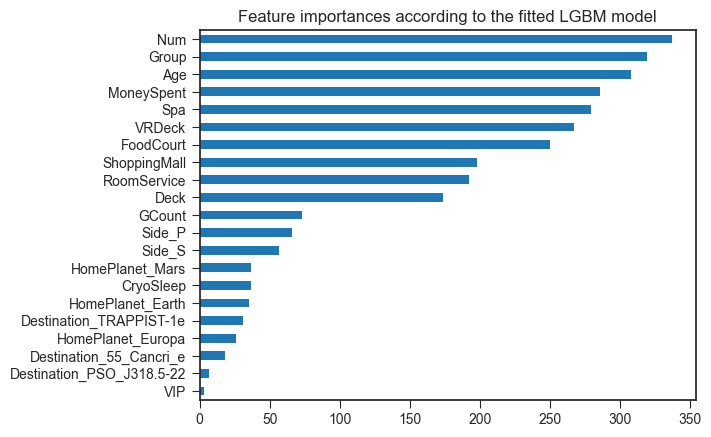

In [247]:
plt.title("Feature importances according to the fitted LGBM model")
feat_importances = pd.Series(model_LGBM.feature_importances_, index=X.columns).sort_values()
feat_importances.plot(kind='barh')
plt.show()

From the LGBM model we can see that the VIP status is actually the least important feature, meaning it probably wouldn't affect whether the passenger was transported or not. The destinations and homeplanets don't have a huge impact either, which makes sense logically. However, removing them from the dataset reduced the prediction accuracy, so they do have some information in them.

Finally lets also try a grid search to see if we find more optimal parameters for the LGBM model.

In [264]:
%%time

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], 
    'objective' : ['binary'],
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

clf = GridSearchCV(model_LGBM, gridParams, n_jobs=-1, verbose=1, cv=5)
clf.fit(X_train,y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
[LightGBM] [Info] Number of positive: 3492, number of negative: 3463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2169
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502085 -> initscore=0.008339
[LightGBM] [Info] Start training from score 0.008339
CPU times: total: 1min 3s
Wall time: 2min 7s


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=0), n_jobs=-1,
             param_grid={'colsample_bytree': [0.64, 0.65, 0.66],
                         'learning_rate': [0.005, 0.01],
                         'n_estimators': [8, 16, 24],
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
                         'random_state': [500], 'reg_alpha': [1, 1.2],
                         'reg_lambda': [1, 1.2, 1.4],
                         'subsample': [0.7, 0.75]},
             verbose=1)

In [265]:
%%time
training_scores=[]
testing_scores=[]
best_model = clf.best_estimator_

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    best_model.fit(X_train,y_train)
    pred_y = best_model.predict(X_test)
    training_scores.append(best_model.score(X_train, y_train))
    testing_scores.append(best_model.score(X_test, y_test))
    
print('Training set score: {:.4f}'.format(np.mean(training_scores)))
print('Test set score: \033[1m {:.4f}\033[0m'.format(np.mean(testing_scores)))

[LightGBM] [Info] Number of positive: 3492, number of negative: 3463
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2169
[LightGBM] [Info] Number of data points in the train set: 6955, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502085 -> initscore=0.008339
[LightGBM] [Info] Start training from score 0.008339
Training set score: 0.7977
Test set score:  0.7975


The model with best parameters from the grid search did not actually improve the results, so the default parameters worked well enough for this dataset.